In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
from IPython.display import clear_output
#%matplotlib inline

### Time Loop

Here is the most important part of the model. For each time step, we do the following:
The following steps are the only ones that apply if we have a one layer system
1. Set noise for the retina $\boldsymbol{S}^x\boldsymbol{x}$ term as an input signal(`Ret["eta"]`)
2. Calculate retina $\boldsymbol{S}H = $  `Ret["u"]` term (solving wave dynamical system)
3. Update retina voltage and threshold according to modified LIF neuron rules
4. Determine which retina neurons are above their threshold and therefore fire
5. Reset the voltage of the retina neurons that fire
6. Set `H` for firing neurons

In [9]:
# System Constants and Parameters
nR = 1600     # Neurons in Retina
sqR = 20


In [10]:
def adjacency(D, ai, ao, ri, ro):
    """Calculate intra-layer adjacency matrix encoding the spatial connectivity 
    of neurons within the layer.

    Parameters
    ----------
    D  : distance matrix
    ai : inhibition amplitude factor
    a0 : excittation amplitude factor
    ri : float
        Excitation radius
    ro : float
        Inhibition radius
    """
    
    S = ai * (D < ri) - (ao * (D > ro) *  np.exp(-D/10))  
    S = S - np.diag(np.diag(S)) 

    return S

In [11]:
# Retina 

Ret = {
    "th" : np.ones((nR, 1)), # variable retina threshold (theta)
    "b" : np.zeros((nR, 1)),
    "v_reset" : .1 * np.random.randn(nR, 1)**2,
    "nx" : sqR * np.random.randn(nR, 2),
    "ri" : 2, # inner radius
    "ro" : 5, # outer radius
    "u" : np.zeros((nR,1)),  # I.C. of v, u
    "v" :  np.zeros((nR, 1)),
    "H" : np.zeros((nR, 1)) # OG has sparse, see if this will be an issue TODO
    # "H" :  sparse(np.zeros((nR,1))) find sparse version in numpy

}
Ret["D"] = squareform(pdist(Ret["nx"])) # distance
Ret["S"] = adjacency(Ret["D"], 16, 3, Ret["ri"], Ret["ro"]) # adjacency matrix 

Tend = 300; dt = 0.1; t_intrvls = np.arange(0,Tend + 1) # (301,) shape

fnoise = 3*np.random.randn(nR,len(t_intrvls)); # Pre-generate noise
# fnoiseI?


Xu = np.zeros((nR,t_intrvls[-1])); Xu[:,0] = Ret["u"].reshape(nR,) # Snapshot matrix u
Xv = np.zeros((nR,t_intrvls[-1])); Xv[:,0] = Ret["v"].reshape(nR,) # Snapshot matrix v
Xth = np.zeros((nR,t_intrvls[-1])); Xth[:,0] = Ret["th"].reshape(nR,)

tau_v = 2; tau_u = 0.3;
tau_th = 60; th_plus = 9; v_th = 1;

firedMat = {} # cell(1,length(t_intrvls)); 


In [13]:
for tt in np.arange(0, Tend, dt):

    if tt < 299:
        #Ret["eta"] = fnoise[:,int(np.round(tt)+1)].reshape(1600,1) # TODO: rounding
        Ret["eta"] = 3 * np.random.randn(1600,1)
        #Ret["eta"] = 10 * np.random.randn(1600,1)

            
        
    # Solve Wave Dynamical System in Retina
    Ret["u"] = np.matmul(Ret["S"],Ret["H"]) # TODO: fix ret.H --> 1600 x 1 of zeros
    
    ## voltage and threshold update rules
    #Ret["v"] = Ret["v"] + dt * (1/tau_v * (-Ret["v"] + Ret["u"] + Ret["b"] + Ret["eta"]))
    Ret["v"] = Ret["v"] + dt * -1/tau_v * Ret["v"] + Ret["u"] + Ret["b"] + Ret["eta"] # incorrect

    Ret["th"] = Ret["th"] +  dt * (1/tau_th * (v_th - Ret["th"]) * (1-Ret["H"]) + th_plus * Ret["H"]) 
                               
    # Discontinuous update rule
    fired = np.argwhere(Ret["v"] >= Ret["th"])[:,0] # get only row indices (#rows, ) shape
    Ret["v"][fired] = Ret["v_reset"][fired] # replacing voltages of fired neurons with reset voltage
    Ret["H"] = np.zeros((nR, 1)) 
    Ret["H"][fired,] = np.ones((len(fired),1)) # 1s where the neurons fire in H #TODOL make sparse
    if np.mod(tt, 1) == 0 and tt != 299:
        
        tt = int(tt)
        Xv[:,tt+1] = Ret["v"].reshape(1600,);
        Xu[:,tt+1] = Ret["u"].reshape(1600,)
        Xth[:,tt+1] = Ret["th"].reshape(1600,);

        firedMat[tt+1] = fired; 
        

bad news: wave happens when the voltage update rule is "wrong". good news: works for noise when u make it new each time or when you take it from fnoise (so its same noise for like 5 time steps, even tho to us we are only plotting every second)

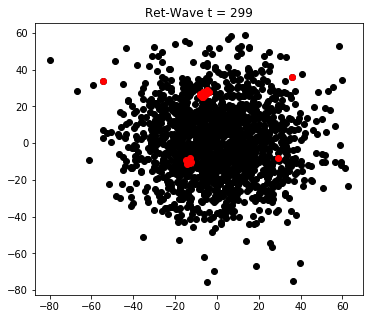

In [14]:
# Visualization of Wave
for ii in range(1, 300):
    f = plt.figure(figsize=(20,5))

    ax1 = f.add_subplot(131)
    ax1.title.set_text('Ret-Wave t = ' + str(ii))
    ax1.scatter(Ret['nx'][:,1],Ret['nx'][:,0], color = 'k')
    ax1.scatter(Ret['nx'][firedMat[ii],1],Ret['nx'][firedMat[ii],0], color = 'r')
    plt.show()
    clear_output(wait=True)

In [ ]:
Ret["v"].shape

In [ ]:
len(X_eta[1])

In [ ]:
len(X_eta)

In [ ]:
plt.plot(range(len(X_eta[1])), X_eta[4])

In [ ]:
for tt in np.arange(0, Tend, dt):

    print (np.round(tt)+1)